# imports

In [1]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import vci
import yaml

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import helpers
import pg

# processing

In [2]:
def split_trials(trials, dataset, ms):
    split = {session: [] for session in trials}

    for session in trials:
        for trial in trials[session]:
            trial_dict = dict()
            keypoints = dataset[session]["keypoints"][trial]
            keypoints = np.reshape(keypoints, (-1, ms, keypoints.shape[-1]))
            keypoints = np.mean(keypoints, axis=1)
            trial_dict["keypoints"] = keypoints

            spikes = dataset[session]["spikes"][trial]
            spikes = np.reshape(spikes, (-1, ms, spikes.shape[-1]))
            spikes = np.sum(spikes, axis=1)
            trial_dict["spikes"] = spikes
            split[session].append(trial_dict)

    return split


def process(dataset, train_trials, val_trials, test_trials, ms=5):
    test_set = split_trials(test_trials, dataset, ms)
    val_set = split_trials(val_trials, dataset, ms)
    train_set = split_trials(train_trials, dataset, ms)

    max_all = max(
        np.max(trial["keypoints"])
        for session in train_set
        for trial in train_set[session]
    )
    min_all = min(
        np.min(trial["keypoints"])
        for session in train_set
        for trial in train_set[session]
    )

    for data_mode in (train_set, test_set, val_set):
        for session in data_mode:
            for trial in data_mode[session]:
                trial["keypoints"] = -1 + 2 * (trial["keypoints"] - min_all) / (
                    max_all - min_all
                )

    return train_set, val_set, test_set

# base dataset

keypoints in global coordinates.

In [ ]:
sessions = [
    x for x in os.listdir("./") if "luk" in x or "jon" in x or "bex" in x
]
dataset = dict()

for session in sessions:
    with open(os.path.join(session, "meta.yml")) as fyaml:
        try:
            monkey = yaml.safe_load(fyaml)
            monkey["session"] = session
        except yaml.YAMLError as exc:
            print(exc)
    dataset[session] = dict()
    dataset[session]["keypoints"] = pg.preprocess_keypoints(
        monkey, from_files=True
    )
    dataset[session]["spikes"] = pg.preprocess_spikes(monkey, from_files=True)

test_trials = {
    "bex_20230226": [1],
    "jon_20230203": [1],
    "luk_20230126": [0],
}
val_trials = {
    "bex_20230226": [2],
    "jon_20230126": [0],
    "luk_20230202": [1],
}
union_trials = {
    key: val_trials.get(key, []) + test_trials.get(key, [])
    for key in set(val_trials) | set(test_trials)
}
train_trials = {
    session: [
        i
        for i in range(len(dataset[session]["keypoints"]))
        if session not in union_trials or i not in union_trials[session]
    ]
    for session in dataset
}

train_set, val_set, test_set = process(
    dataset, train_trials, val_trials, test_trials
)
data = {"train": train_set, "validation": val_set, "test": test_set}

with open("pg.pkl", "wb") as f:
    pickle.dump(data, f)

# old dataset

only bex and being conservative with the good frames.

In [ ]:
sessions = [x for x in os.listdir("./") if "bex" in x]
dataset = dict()

for session in sessions:
    with open(f"{session}/old_meta.yml") as fyaml:
        try:
            monkey = yaml.safe_load(fyaml)
            monkey["session"] = session
        except yaml.YAMLError as exc:
            print(exc)
    dataset[session] = dict()
    dataset[session]["keypoints"] = pg.preprocess_keypoints(monkey)
    dataset[session]["spikes"] = pg.preprocess_spikes(monkey)

test_trials = {"bex_20230226": [1]}
val_trials = {"bex_20230226": [2]}
union_trials = {
    key: val_trials.get(key, []) + test_trials.get(key, [])
    for key in set(val_trials) | set(test_trials)
}
train_trials = {
    session: [
        i
        for i in range(len(dataset[session]["keypoints"]))
        if session not in union_trials or i not in union_trials[session]
    ]
    for session in dataset
}

train_set, val_set, test_set = process(
    dataset, train_trials, val_trials, test_trials
)
data = {"train": train_set, "validation": val_set, "test": test_set}

with open("pg_old.pkl", "wb") as f:
    pickle.dump(data, f)

# new old dataset

added monkeys, but for testing i'm still using the exact same old dataset without increasing the number of frames.

In [ ]:
sessions = [
    x for x in os.listdir("./") if "luk" in x or "jon" in x or "bex" in x
]
dataset = dict()

for session in sessions:
    if "bex" in session:
        with open(os.path.join(session, "old_meta.yml")) as fyaml:
            try:
                monkey = yaml.safe_load(fyaml)
            except yaml.YAMLError as exc:
                print(exc)
    else:
        with open(os.path.join(session, "meta.yml")) as fyaml:
            try:
                monkey = yaml.safe_load(fyaml)
            except yaml.YAMLError as exc:
                print(exc)
    monkey["session"] = session
    dataset[session] = dict()
    dataset[session]["keypoints"] = pg.preprocess_keypoints(monkey)
    dataset[session]["spikes"] = pg.preprocess_spikes(monkey)

test_trials = {
    "bex_20230226": [1],
    "jon_20230203": [1],
    "luk_20230126": [0],
}
val_trials = {
    "bex_20230226": [2],
    "jon_20230126": [0],
    "luk_20230202": [1],
}
union_trials = {
    key: val_trials.get(key, []) + test_trials.get(key, [])
    for key in set(val_trials) | set(test_trials)
}
train_trials = {
    session: [
        i
        for i in range(len(dataset[session]["keypoints"]))
        if session not in union_trials or i not in union_trials[session]
    ]
    for session in dataset
}

train_set, val_set, test_set = process(
    dataset, train_trials, val_trials, test_trials
)
data = {"train": train_set, "validation": val_set, "test": test_set}

with open("pg_new_old.pkl", "wb") as f:
    pickle.dump(data, f)

# nose dataset

nose in global coordinates and the other keypoints are relative (difference) to the nose.

In [8]:
with open("pg.pkl", "rb") as old:
    old_data = pickle.load(old)
    with open("pg_nose.pkl", "wb") as new:
        new_data = helpers.compute_differences(
            old_data, nose_idx=3, add_nose=True
        )
        pickle.dump(new_data, new)

# noseless dataset

In [2]:
with open("pg.pkl", "rb") as old:
    old_data = pickle.load(old)
    with open("pg_noseless.pkl", "wb") as new:
        new_data = helpers.compute_differences(
            old_data, nose_idx=3, add_nose=False
        )
        pickle.dump(new_data, new)

# centered dataset

In [2]:
with open("pg.pkl", "rb") as old:
    old_data = pickle.load(old)
    with open("pg_centered.pkl", "wb") as new:
        new_data = helpers.center_head_differences(
            old_data, l_ear_idx=1, r_ear_idx=2, add_center=True
        )
        pickle.dump(new_data, new)

# uncentered dataset

In [3]:
with open("pg.pkl", "rb") as old:
    old_data = pickle.load(old)
    with open("pg_uncentered.pkl", "wb") as new:
        new_data = helpers.center_head_differences(
            old_data, l_ear_idx=1, r_ear_idx=2, add_center=False
        )
        pickle.dump(new_data, new)

# head dataset

change the coordinate system such that the origin is the nose, the x-axis is the vector nose-neck, the y-axis is the vector nose-l_ear and the z-axis is the vector nose-r_ear

In [5]:
with open("pg.pkl", "rb") as old:
    old_data = pickle.load(old)
    with open("pg_head.pkl", "wb") as new:
        new_data = helpers.head_coordinates(
            old_data, face_idxs=[0, 1, 2, 3], add_nose=True
        )
        pickle.dump(new_data, new)

# noseless head dataset

i remove the nose (origin) from the head dataset, which means there's only information about the monkeys' body, but not where he's in the room.

In [6]:
with open("pg.pkl", "rb") as old:
    old_data = pickle.load(old)
    with open("pg_noseless_head.pkl", "wb") as new:
        new_data = helpers.head_coordinates(
            old_data, face_idxs=[0, 1, 2, 3], add_nose=False
        )
        pickle.dump(new_data, new)

# orthogonal head dataset

In [7]:
with open("pg.pkl", "rb") as old:
    old_data = pickle.load(old)
    with open("pg_orthogonal_head.pkl", "wb") as new:
        new_data = helpers.orthogonal_head_coordinates(
            old_data, face_idxs=[1, 2, 3], add_origin=True
        )
        pickle.dump(new_data, new)

# originless orthogonal head dataset

In [8]:
with open("pg.pkl", "rb") as old:
    old_data = pickle.load(old)
    with open("pg_originless_orthogonal_head.pkl", "wb") as new:
        new_data = helpers.orthogonal_head_coordinates(
            old_data, face_idxs=[1, 2, 3], add_origin=False
        )
        pickle.dump(new_data, new)

# low pass filtered dataset

applies a Butterworth filter of order 4 and cutoff frequency of 2Hz

In [ ]:
sessions = [
    "bex_20230221",
    "bex_20230222",
    "bex_20230223",
    "bex_20230224",
    "bex_20230225",
    "bex_20230226",
]
dataset = dict()

for session in sessions:
    with open(f"{session}/meta.yml") as fyaml:
        try:
            monkey = yaml.safe_load(fyaml)
            monkey["session"] = session
        except yaml.YAMLError as exc:
            print(exc)
    dataset[session] = dict()
    dataset[session]["keypoints"] = pg.preprocess_keypoints(monkey)
    dataset[session]["spikes"] = pg.preprocess_spikes(monkey)

for session in dataset:
    for tr in range(len(dataset[session]["spikes"])):
        for ch in range(dataset[session]["spikes"][tr].shape[1]):
            dataset[session]["spikes"][tr][:, ch] = helpers.lowpass_filter(
                dataset[session]["spikes"][tr][:, ch], cutoff=2
            )

data = process(dataset)

with open("pg_lowfilter.pkl", "wb") as f:
    pickle.dump(data, f)

# medium pass filtered dataset

applies a Butterworth filter of order 4 and cutoff frequency of 10Hz

In [7]:
sessions = [
    "bex_20230221",
    "bex_20230222",
    "bex_20230223",
    "bex_20230224",
    "bex_20230225",
    "bex_20230226",
]
dataset = dict()

for session in sessions:
    with open(f"{session}/meta.yaml") as fyaml:
        try:
            monkey = yaml.safe_load(fyaml)
            monkey["session"] = session
        except yaml.YAMLError as exc:
            print(exc)
    dataset[session] = dict()
    dataset[session]["keypoints"] = pg.preprocess_keypoints(monkey)
    dataset[session]["spikes"] = pg.preprocess_spikes(monkey)

for session in dataset:
    for tr in range(len(dataset[session]["spikes"])):
        for ch in range(dataset[session]["spikes"][tr].shape[1]):
            dataset[session]["spikes"][tr][:, ch] = helpers.lowpass_filter(
                dataset[session]["spikes"][tr][:, ch], cutoff=10
            )

data = process(dataset)

with open("pg_mediumfilter.pkl", "wb") as f:
    pickle.dump(data, f)

# pca

dataset where i extract the first two principal components of the neural data. should be easier to predict.

In [8]:
sessions = [
    "bex_20230221",
    "bex_20230222",
    "bex_20230223",
    "bex_20230224",
    "bex_20230225",
    "bex_20230226",
]
dataset = dict()
n_comps = 2

for session in sessions:
    with open(f"{session}/meta.yaml") as fyaml:
        try:
            monkey = yaml.safe_load(fyaml)
            monkey["session"] = session
        except yaml.YAMLError as exc:
            print(exc)
    dataset[session] = dict()
    dataset[session]["keypoints"] = pg.preprocess_keypoints(monkey)
    dataset[session]["spikes"] = pg.preprocess_spikes(
        monkey, pca=True, n_comps=2
    )

data = process(dataset)

with open("pg_pca.pkl", "wb") as f:
    pickle.dump(data, f)

# random

dataset with Gaussian noise as input. the goal is to check whether the model learns anything from the input.

In [7]:
with open("pg.pkl", "rb") as old:
    old_data = pickle.load(old)
    with open("pg_random.pkl", "wb") as new:
        new_data = helpers.randomize(old_data)
        pickle.dump(new_data, new)

# debugging

### dimensions

In [14]:
def check(data):
    for mode in ("train", "validation", "test"):
        for session in data[mode]:
            for trial in data[mode][session]:
                keypoints = trial["keypoints"]
                spikes = trial["spikes"]
                assert keypoints.shape[0] == spikes.shape[0]


with open("pg.pkl", "rb") as f:
    base = pickle.load(f)

check(base)

with open("pg_diff.pkl", "rb") as f:
    diff = pickle.load(f)

check(diff)

with open("pg_head.pkl", "rb") as f:
    head = pickle.load(f)

check(head)

# with open("pg_lowfilter.pkl", "rb") as f:
#     lowfilter = pickle.load(f)

# check(lowfilter)

# with open("pg_mediumfilter.pkl", "rb") as f:
#     mediumfilter = pickle.load(f)

# check(mediumfilter)

# with open("pg_pca.pkl", "rb") as f:
#     pca = pickle.load(f)

# check(pca)

with open("pg_random.pkl", "rb") as f:
    random = pickle.load(f)

check(random)

### poses

In [15]:
skeleton = [
    [16, 17],
    [16, 10],
    [16, 13],
    [14, 13],
    [14, 15],
    [11, 10],
    [11, 12],
    [8, 7],
    [8, 9],
    [5, 4],
    [5, 6],
    [0, 16],
    [0, 3],
    [0, 4],
    [0, 7],
    [0, 1],
    [0, 2],
    [3, 1],
    [3, 2],
]

In [16]:
with open("pg.pkl", "rb") as f:
    data = pickle.load(f)

keypoints = data["train"]["bex_20230226"][0]["keypoints"]
print(len(keypoints))
keypoints = keypoints[2900]
print(keypoints.shape)
keypoints = np.reshape(keypoints, (-1, 18, 3))
vci.plot.plot_pose(keypoints[0], skeleton)

10080
(54,)


In [17]:
with open("pg_nose.pkl", "rb") as f:
    data = pickle.load(f)
    data = helpers.undo_differences(data, nose_idx=3)

keypoints = data["train"]["bex_20230226"][0]["keypoints"]
print(len(keypoints))
keypoints = keypoints[2900]
print(keypoints.shape)
keypoints = np.reshape(keypoints, (-1, 18, 3))
vci.plot.plot_pose(keypoints[0], skeleton)

10080
(54,)


### filters

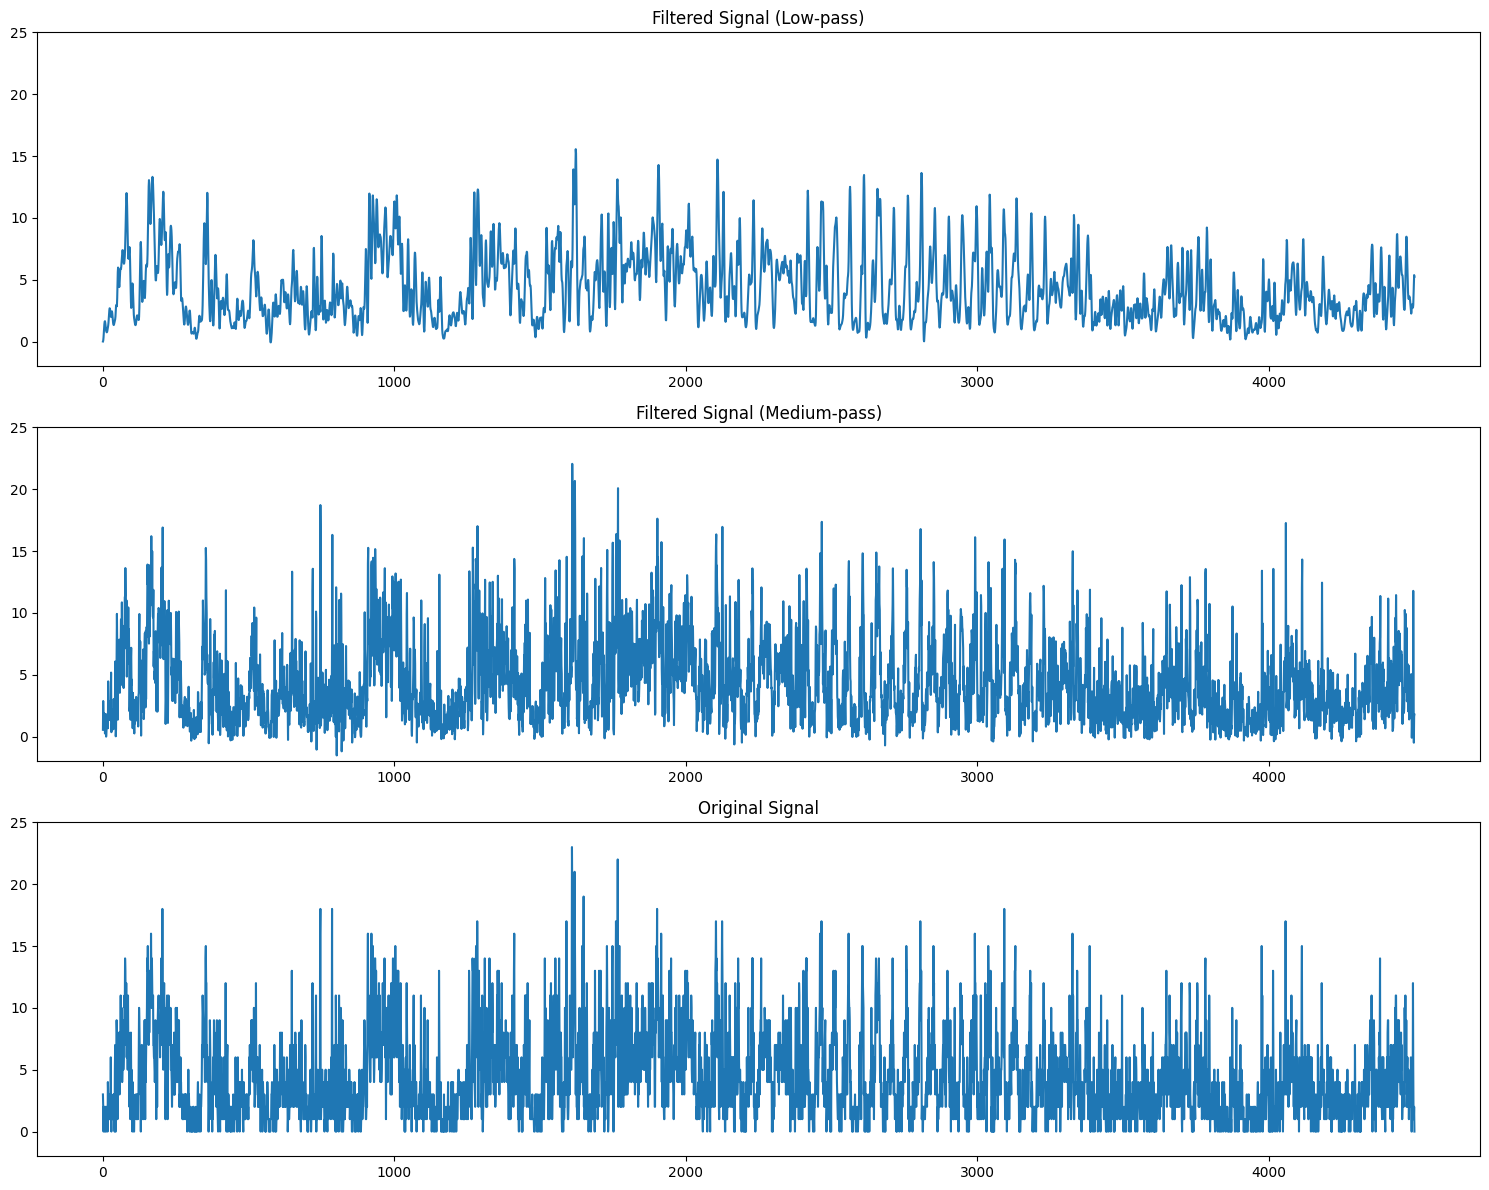

In [16]:
with open("pg.pkl", "rb") as f:
    base = pickle.load(f)

with open("pg_lowfilter.pkl", "rb") as f:
    lowfilter = pickle.load(f)

with open("pg_mediumfilter.pkl", "rb") as f:
    mediumfilter = pickle.load(f)

mode = "test"
session = "bex_20230226"
fig, axs = plt.subplots(3, 1, figsize=(15, 12))

axs[0].plot(lowfilter[mode][session]["trial_0"]["spikes"][:, 0], label="low")
axs[0].set_title("Filtered Signal (Low-pass)")
axs[0].set_ylim(-2, 25)

axs[1].plot(
    mediumfilter[mode][session]["trial_0"]["spikes"][:, 0], label="medium"
)
axs[1].set_title("Filtered Signal (Medium-pass)")
axs[1].set_ylim(-2, 25)

axs[2].plot(base[mode][session]["trial_0"]["spikes"][:, 0], label="raw")
axs[2].set_title("Original Signal")
axs[2].set_ylim(-2, 25)

plt.tight_layout()

In [17]:
corr = 0
n_channels = base[mode][session]["trial_0"]["spikes"].shape[1]

for ch in range(n_channels):
    corr += np.corrcoef(
        base[mode][session]["trial_0"]["spikes"][:, ch],
        lowfilter[mode][session]["trial_0"]["spikes"][:, ch],
    )[0, 1]

corr /= n_channels
print(corr)

0.48775280339899846


### head coordinates

In [18]:
with open("pg_head.pkl", "rb") as f:
    data = pickle.load(f)

keypoints = data["train"]["bex_20230224"][0]["keypoints"][0].reshape(19, 3)
print(keypoints)

[[  1.           0.           0.        ]
 [  0.           1.           0.        ]
 [  0.           0.           1.        ]
 [  0.           0.           0.        ]
 [  6.76676561  -3.15568817  -5.42406275]
 [ 17.70889568  -9.9284868  -14.1638877 ]
 [ 25.25618452 -15.28362051 -20.41034357]
 [  7.43834829  -4.87309248  -4.95914876]
 [ 19.95048997 -12.46756955 -15.03626837]
 [ 27.85557847 -17.23402294 -22.00513604]
 [ 11.55803862  -5.15488532  -7.18664903]
 [ 25.5572195  -14.0942151  -18.77504119]
 [ 33.76463121 -18.82930667 -25.08774947]
 [ 13.51595145  -8.04456248  -7.72841095]
 [ 23.75312458 -14.2147675  -16.87571156]
 [ 32.88923655 -19.61544061 -24.26908854]
 [ 10.34553092  -4.98564499  -5.30902115]
 [ 25.12814004 -14.56371025 -16.39311859]
 [  0.64079524   0.03908474  -0.20217272]]
